In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [24]:
import os

home = '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/'

imroot = home+'images'
os.chdir(home)

In [25]:
prefix = 'charts'

In [26]:
import json
import ast
datalen = 0
dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "charts", "license": {}, "data_subtype": prefix, "questions": [] }

with open(home+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  global datalen
  datalen = len(data)
  for i in data[0:int(datalen*0.8)]:
    ijson = json.loads(i)
    imlist = ast.literal_eval(ijson['images'])
    #print(imlist)
    anslist = ast.literal_eval(ijson['answer_choices'])
    #print(anslist)
    if len(anslist)==2:
      anslist.append("Unknown")
      anslist.append("Unanswerable")
    try:
      #print(len(anslist))
      assert len(anslist) == 4
    except:
      print(i)
    dumpdict['questions'].append( { "image_id": imroot+"/"+imlist[0].replace("./images/", ""), "question": ijson['question']+" "+ijson['passage'], "question_id": ijson['qid'], "answer_choices": anslist, "answer_id": int(ijson['answer']) } )

with open('/content/'+prefix+'_train.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

251
{'info': {}, 'task_type': 'Open-Ended', 'data_type': 'charts', 'license': {}, 'data_subtype': 'charts', 'questions': [{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/images/21.png', 'question': 'From the above graph infer comparatively which country is most likely to have highest per capita income? The above visualization shows health care expenditure across countries. There is a strong correlation between health care expenditure and national income. The countries which spend more on health care are more likely to have highest per capita income.', 'question_id': 2218, 'answer_choices': ['United States', 'United Kingdom', 'India', 'Iraq'], 'answer_id': 0}, {'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/images/21.png', 'question': 'How many countries are most likely to have better per capita income level than Iraq? The above visualization shows health care expenditure across countries. There is a strong correlation between health care ex

In [27]:
import json
f = open('/content/'+prefix+'_train.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 200


In [28]:
questions[0]

{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/images/21.png',
 'question': 'From the above graph infer comparatively which country is most likely to have highest per capita income? The above visualization shows health care expenditure across countries. There is a strong correlation between health care expenditure and national income. The countries which spend more on health care are more likely to have highest per capita income.',
 'question_id': 2218,
 'answer_choices': ['United States', 'United Kingdom', 'India', 'Iraq'],
 'answer_id': 0}

In [29]:
from os import listdir
from os.path import isfile, join

file_names = [f for f in listdir(imroot) if isfile(join(imroot, f))]
print(file_names)
print(len(file_names))

['central-bank-discount-rate_Mexico.png', 'stock-of-broad-money_United_States.png', 'gdp-real-growth-rate_Puerto_Rico.png', 'gross-national-saving_United_States.png', 'exports_United_Kingdom.png', 'distribution-of-family-income-gini-index_India.png', 'distribution-of-family-income-gini-index_United_States.png', 'stock-of-direct-foreign-investment-abroad_United_States.png', 'gross-national-saving_South_Africa.png', 'gdp-real-growth-rate_Saudi_Arabia_Qatar.png', 'current-account-balance_India_European_Union.png', 'military-expenditures_United_States.png', 'commercial-bank-prime-lending-rate_Argentina.png', 'commercial-bank-prime-lending-rate_Argentina_Brazil.png', 'central-bank-discount-rate_France.png', 'gdp-real-growth-rate_Brazil.png', 'gdp-real-growth-rate_Venezuela.png', 'central-bank-discount-rate_Germany_France.png', 'reserves-of-foreign-exchange-and-gold_India.png', 'distribution-of-family-income-gini-index_United_States_Canada_Mexico.png', 'inflation-rate-consumer-prices_United_

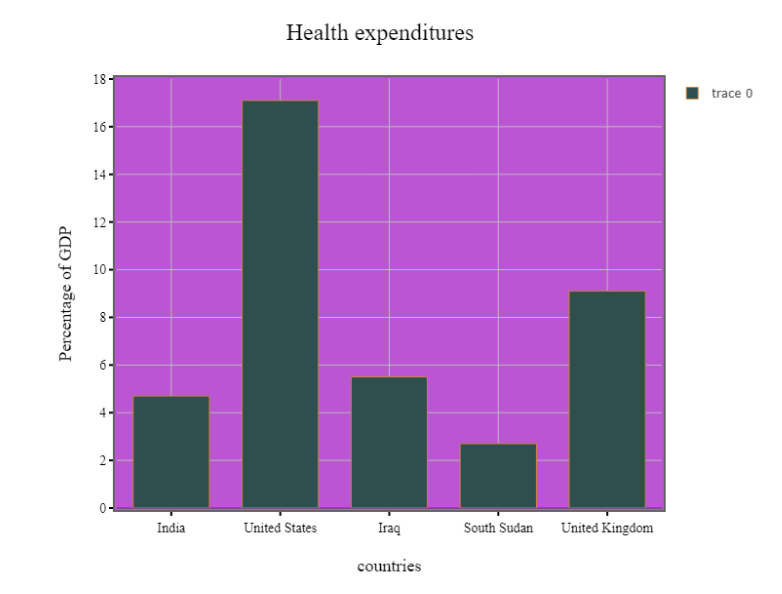

In [30]:
from PIL import Image

path = questions[0]['image_id']
image = Image.open(path)
image

In [31]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

In [32]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, processor):
        self.questions = questions
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        questions = self.questions[idx]
        image = Image.open(questions['image_id']).convert("RGB")
        text = questions['question']
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        targets = torch.zeros(len(questions['answer_choices']))
        targets[questions['answer_id']] = 1.0
        encoding["labels"] = targets
        return encoding

In [33]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [34]:
dataset = VQADataset(questions=questions,processor=processor)

In [35]:
dataset[0]

{'input_ids': tensor([  101,  2013,  1996,  2682, 10629,  1999,  7512, 20172,  2029,  2406,
         2003,  2087,  3497,  2000,  2031,  3284,  2566,  8353,  3318,  1029,
         1996,  2682,  5107,  3989,  3065,  2740,  2729, 20700,  2408,  3032,
         1012,  2045,  2003,  1037,  2844, 16902,  2090,  2740,  2729,   102]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'pixel_values': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],


In [36]:
dataset[1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [37]:
len(dataset)

200

In [38]:
processor.decode(dataset[0]['input_ids'])

'[CLS] from the above graph infer comparatively which country is most likely to have highest per capita income? the above visualization shows health care expenditure across countries. there is a strong correlation between health care [SEP]'

In [39]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()
labels

0

In [40]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm", num_labels=4)

model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [41]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = torch.stack(pixel_values)
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

In [42]:
batch = next(iter(train_dataloader))

In [43]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([1, 40])
attention_mask torch.Size([1, 40])
token_type_ids torch.Size([1, 40])
pixel_values torch.Size([1, 3, 384, 448])
pixel_mask torch.Size([1, 384, 448])
labels torch.Size([1, 4])


## Start Training

In [44]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# -- CHANGE BASED ON HOW MANY EPOCHS YOU WANT TO RUN FOR
e = 5

model.train()
for epoch in range(e):
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        batch = {k:v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        #print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/200 [00:00<?, ?it/s]

## Inference

In [46]:
import json
import ast
datalen = 0
dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "charts", "license": {}, "data_subtype": prefix, "questions": [] }

with open(home+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  global datalen
  datalen = len(data)
  for i in data[int(datalen*0.8):datalen]:
    test_ijson = json.loads(i)
    test_imlist = ast.literal_eval(test_ijson['images'])
    #print(imlist)
    test_anslist = ast.literal_eval(test_ijson['answer_choices'])
    if len(test_anslist)==2:
      test_anslist.append("Unknown")
      test_anslist.append("Unanswerable")
    #print(anslist)
    try:
      #print(len(anslist))
      assert len(test_anslist) == 4
    except:
      print(i)
    dumpdict['questions'].append( { "image_id": imroot+"/"+test_imlist[0].replace("./images/", ""), "question": test_ijson['question']+" "+test_ijson['passage'], "question_id": test_ijson['qid'], "answer_choices": test_anslist, "answer_id": int(test_ijson['answer']) } )

with open('/content/'+prefix+'_test.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

251
{'info': {}, 'task_type': 'Open-Ended', 'data_type': 'charts', 'license': {}, 'data_subtype': 'charts', 'questions': [{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/images/1.png', 'question': 'The industrial production growth rate of Pakistan is almost equal to Figure shows the industrial production growth rate for various countries in the year of 2017. Industrial production figures are used by central banks to measure inflation, as high levels of industrial production can lead to uncontrolled levels of consumption and rapid inflation. In 2017, the industrial production growth rate of India was similar to that of Pakistan.', 'question_id': 2418, 'answer_choices': [7.5, 6.5, 5.5, 4.5], 'answer_id': 2}, {'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/VLQAv1/Charts/images/1.png', 'question': 'Consider all the given 6 countries. The industrial production growth rate of Sri Lanka is less than how many countries Figure shows the industrial production grow

In [47]:
import json
f = open('/content/'+prefix+'_test.jsonl','r')
test_data_questions = json.load(f)
test_questions = test_data_questions['questions']

print(test_data_questions.keys())
print("Number of questions:", len(test_questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 51


In [48]:
test_dataset = VQADataset(questions=test_questions,processor=processor)

In [49]:
len(test_dataset)

51

# Single Instance Inference

In [50]:
exid = 1
example = test_dataset[exid]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [51]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [52]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", predicted_class)
print("Ground-truth answer:", test_dataset[exid]['labels'].argmax(-1).item())

Predicted answer: 1
Ground-truth answer: 3


# Batch Inference

In [53]:
import csv
filprefix = prefix+"_result"

count = 0
st = 0
end = datalen-int(datalen*0.8)
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end):
    correctness = 0
    example = test_dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = test_dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])